In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score as ras 
from sklearn.metrics import  confusion_matrix, ConfusionMatrixDisplay
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector

## Loading the data

We are using pd.read_csv function to loading the data from CSV to DataFrame and nrows parameter is for loading the 10000 row from the csv file

In [2]:
df = pd.read_csv("onlinefraud.csv", nrows=1_000_00)
# df.info()
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Checking the null values

Checking the Null Values 

In [3]:
df.isnull().sum() 

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Here is no any null Values so no need to handle this

## Sampling the data

Sampling the data to check how many number of columns are int, float, object present in the dataset 

In [4]:
object = (df.dtypes == 'object')
object_columns = list(object[object].index)
print("Categorial Values" , len(object_columns))

integer = (df.dtypes == 'int')
integer_columns = list(integer[integer].index)
print("Ineger columns ", len(integer_columns))

float = (df.dtypes == 'float')
float_columns = list(float[float].index)
print("Float columns ", len(float_columns))

Categorial Values 3
Ineger columns  3
Float columns  5


## Ploting the graph

Ploting the graph to check the hightest faurd are in which payment type and checking the relation between type and amount column

<Axes: xlabel='type', ylabel='amount'>

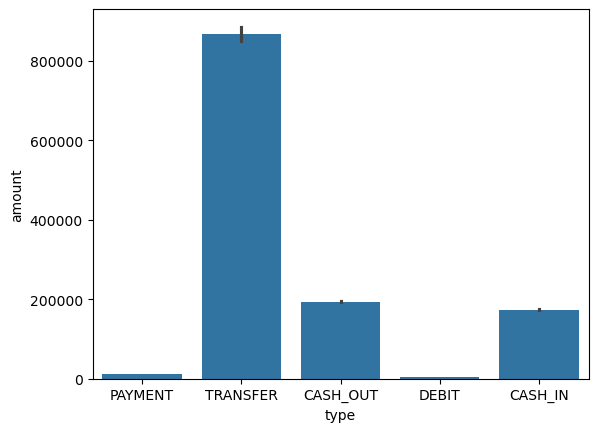

In [5]:
sns.barplot(x='type', y='amount', data=df)

## Scale the Values

Here We are Scaling the Vlaues of some int. Column using normalize it will arrange the all values between 0 to 1 according to their values

In [6]:
# Scale the column
columns_to_scale = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Implement the  normalization 
minmax_scaler = MinMaxScaler()

df[columns_to_scale] = minmax_scaler.fit_transform(df[columns_to_scale])

print("Normalized Data :", df[columns_to_scale].head())



Normalized Data :      amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest
0  0.000984       0.005034        0.004713        0.000000             0.0
1  0.000186       0.000629        0.000570        0.000000             0.0
2  0.000018       0.000005        0.000000        0.000000             0.0
3  0.000018       0.000005        0.000000        0.000623             0.0
4  0.001167       0.001230        0.000879        0.000000             0.0


Counting the Values of isFraud 

In [7]:
df['isFraud'].value_counts()

isFraud
0    99884
1      116
Name: count, dtype: int64

## EDA
Ploting the EDA to the distribution of values in the step column in the dataset

<Axes: xlabel='step', ylabel='Count'>

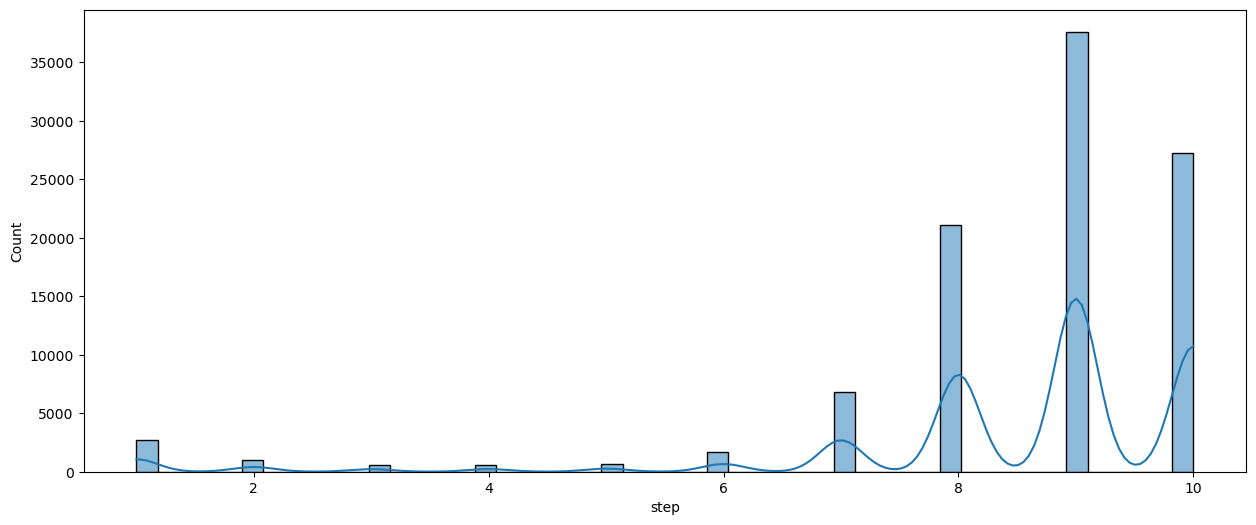

In [8]:
plt.figure(figsize=(15, 6))
sns.histplot(df['step'], bins=50, kde=True)  


## Correlation
Checking the coorelation between all columns

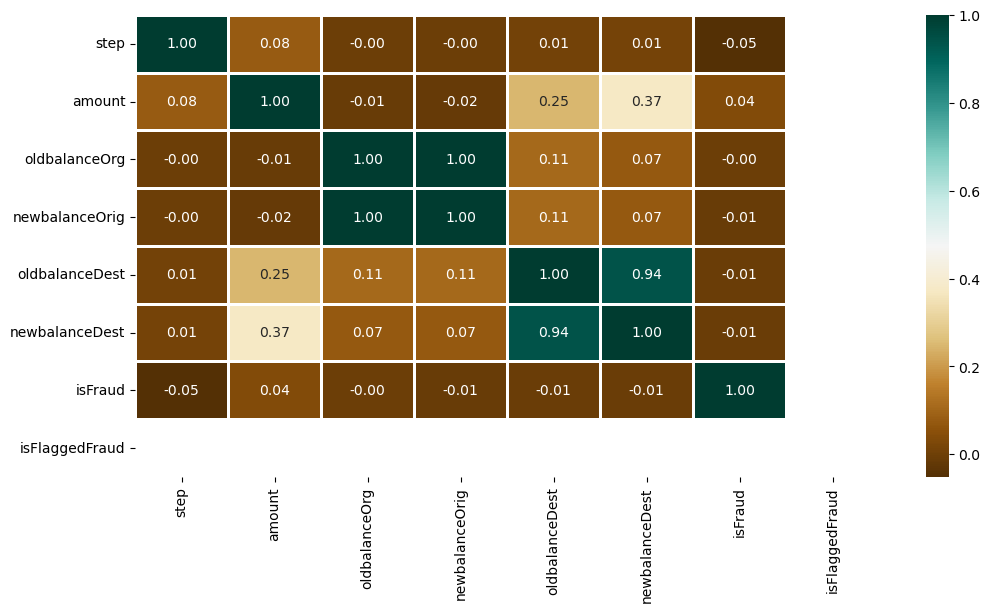

In [9]:
numeric_df = df.select_dtypes(include=[np.number])

# Plotting the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(numeric_df.corr(),
            cmap='BrBG',
            fmt='.2f',
            linewidths=2,
            annot=True)
plt.show()


Here In result we can see the correalation beloween the all the columns like (step==amount -0.02) here is some good correlation between (isFaurd and amount)

## Data Labeling
text column type into numerical columns so that a machine learning model can work with it

In [10]:

type_new = pd.get_dummies(df['type'], drop_first=True)
df_new = pd.concat([df, type_new], axis=1)
df_new.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,PAYMENT,0.000984,C1231006815,0.005034,0.004713,M1979787155,0.000000,0.0,0,0,False,False,True,False
1,1,PAYMENT,0.000186,C1666544295,0.000629,0.000570,M2044282225,0.000000,0.0,0,0,False,False,True,False
2,1,TRANSFER,0.000018,C1305486145,0.000005,0.000000,C553264065,0.000000,0.0,1,0,False,False,False,True
3,1,CASH_OUT,0.000018,C840083671,0.000005,0.000000,C38997010,0.000623,0.0,1,0,True,False,False,False
4,1,PAYMENT,0.001167,C2048537720,0.001230,0.000879,M1230701703,0.000000,0.0,0,0,False,False,True,False


Selecting the Feature and Target from the new_df

In [11]:
X = df_new.drop(['isFraud', 'type', 'nameOrig', 'nameDest', 'isFlaggedFraud', 'DEBIT', 'CASH_OUT', 'TRANSFER', 'PAYMENT'], axis=1)
y = df_new['isFraud']

In [12]:
X

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,1,0.000984,0.005034,0.004713,0.000000,0.000000
1,1,0.000186,0.000629,0.000570,0.000000,0.000000
2,1,0.000018,0.000005,0.000000,0.000000,0.000000
3,1,0.000018,0.000005,0.000000,0.000623,0.000000
4,1,0.001167,0.001230,0.000879,0.000000,0.000000
...,...,...,...,...,...,...
99995,10,0.000402,0.004732,0.004584,0.000000,0.000000
99996,10,0.001835,0.000184,0.000000,0.000000,0.000000
99997,10,0.018377,0.001159,0.006556,0.001615,0.000000
99998,10,0.008224,0.000178,0.000000,0.017426,0.020519


In [13]:
y

0        0
1        0
2        1
3        1
4        0
        ..
99995    0
99996    0
99997    0
99998    0
99999    0
Name: isFraud, Length: 100000, dtype: int64

In [14]:
X.shape, y.shape

((100000, 6), (100000,))

## Spliting the data 
Divide the data into training and testing

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

## Models

Implement the Logistic model and check the accuracy

In [16]:
print("Logistic")
Logistic_model =  LogisticRegression()
Logistic_model.fit(X_train, y_train)
train_pred = Logistic_model.predict_proba(X_train)[:,1]
print("Training Accuracy", ras(y_train, train_pred))
y_pred = Logistic_model.predict_proba(X_test)[:,1]
print("Testing Accuracy", ras(y_test, y_pred))

Logistic
Training Accuracy 0.8237590147767292
Testing Accuracy 0.8395022403431653


Implement the XGB model and check the accuracy

In [17]:
print("XBG")
Xgb_model =  XGBClassifier()
Xgb_model.fit(X_train, y_train)
train_pred = Xgb_model.predict_proba(X_train)[:,1]
print("Training Accuracy", ras(y_train, train_pred))
y_pred = Xgb_model.predict_proba(X_test)[:,1]
print("Testing Accuracy", ras(y_test, y_pred))

XBG
Training Accuracy 0.9999992245538644
Testing Accuracy 0.983253295797094


Implement the SVC model and check the accuracy

In [18]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")
train_pred = best_xgb.predict_proba(X_train)[:, 1]
print("Training Accuracy (AUC):", ras(y_train, train_pred))
y_pred = best_xgb.predict_proba(X_test)[:, 1]
print("Testing Accuracy (AUC):", ras(y_test, y_pred))


Fitting 3 folds for each of 27 candidates, totalling 81 fits


/home/mobcoder/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:00:57] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/mobcoder/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:00:57] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/mobcoder/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:00:57] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/mobcoder/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:00:57] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn

Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'subsample': 0.5}
Training Accuracy (AUC): 0.9995780711414963
Testing Accuracy (AUC): 0.9796387136961769


/home/mobcoder/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:01:01] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [19]:
print("SVC")
Svc_model =  SVC(kernel= 'rbf', probability= True)
Svc_model.fit(X_train, y_train)
train_pred = Svc_model.predict_proba(X_train)[:,1]
print("Training Accuracy", ras(y_train, train_pred))
y_pred = Svc_model.predict_proba(X_test)[:,1]
print("Testing Accuracy", ras(y_test, y_pred))

SVC
Training Accuracy 0.6712318616686808
Testing Accuracy 0.6485477459548938


Implement the Random Classifier model and check the accuracy

In [20]:
print("Random Forest")
Random_model = RandomForestClassifier(n_estimators= 10, criterion= 'entropy', random_state=14) 
Random_model.fit(X_train, y_train)
train_pred = Random_model.predict_proba(X_train)[:,1]
print("Training Accuracy", ras(y_train, train_pred))
y_pred = Random_model.predict_proba(X_test)[:,1]
print("Testing Accuracy", ras(y_test, y_pred))

Random Forest
Training Accuracy 0.9999998276786365
Testing Accuracy 0.8776720048619138


#### Here we can see XGB Booost is giving the best accuracy

## Confusion Matrix
It 's a tool to check the performance of our model

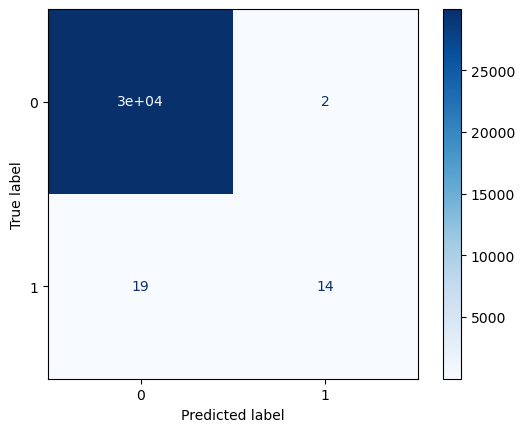

In [21]:
y_pred = Xgb_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [22]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[29965     2]
 [   19    14]]


# Serilization

Saving the Model in our local

In [23]:
joblib.dump(Xgb_model, 'XGB_model.joblib')
print("Model saved successfully!")

Model saved successfully!


## Pipeline 

Here we are creating the pipline to excute some sequencal operation 

In [24]:
preprocessor = ColumnTransformer(
    [
        (
            "cat",
            Pipeline(
                [
                    ("encoder", OneHotEncoder()),
                    (
                        "imputer",
                        MinMaxScaler(),
                    ),
                ]
            ),
            selector(dtype_include=["object", "category"]),
        ),
        (
            "num",
            Pipeline(
                [
                    ("imputer", MinMaxScaler()),
                ]
            ),
            selector(dtype_include=["int64", "float64"]),
        ),
    ],
    remainder="passthrough",
)

In [25]:
pipe = Pipeline(
    steps=[
        ("Preprocessor", preprocessor),
    ]
)

In [26]:
pipe.fit(X)

Pipeline(steps=[('Preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder()),
                                                                  ('imputer',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x769823f3de50>),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x769823f3f5f0>)]))])

In [27]:
X_mod = pipe.transform(X)
columns = pipe.get_feature_names_out()

In [28]:
X_mod = pd.DataFrame(X_mod, columns=columns)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X_mod, y, test_size=0.3, random_state=42)

In [30]:
Xgb_model.fit(X_train, y_train)
pred = Xgb_model.predict(X_test)
print(ras(y_test, pred))

0.7120878420808344


In [31]:
joblib.dump(pipe, 'Pipeline_XGB_model.joblib')

['Pipeline_XGB_model.joblib']